# *Лабораторная работа №3*

## Классификация изображений (Теоретическая часть)

Подключим все необходимые библиотеки.

In [ ]:
from zipfile import ZipFile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from PIL import Image
import os
import keras
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Загрузим датасет в среду выполнения.

In [ ]:
%%capture
!wget https://www.dropbox.com/s/7xi7of75tbuouo2/Meta.zip

Распакуем все данные для дальнейшей работы.

In [ ]:
zip = ZipFile('Meta.zip')
zip.extractall()

Укажем основные пути к папкам и введем масштаб, к которому будем приводить все изображения датасета.

In [ ]:
data_dir = '/content/'
train_path = '/content/Train'

height = 30
width = 30
channels = 3

Создадим массивы для хранения изображений и их категорий. Дополнительно рассмотрим общее количество категорий в данном датасете.

In [ ]:
data = []
labels = []
NUM_CATEGORIES = len(os.listdir(train_path))
NUM_CATEGORIES

43

Заполним массивы изображений и меток классов.

In [ ]:
for i in range(NUM_CATEGORIES):
    path = os.path.join(train_path,str(i))
    images = os.listdir(path)
    for a in images:
            image = Image.open(path + '/' + a)
            image = image.resize((height,width))
            image = np.array(image)
            data.append(image)
            labels.append(i)

data = np.array(data)
labels = np.array(labels)

Разобьем данные на тренировочную и тестовую выборки в рамках обучения нейронной сети. Также проведем нормализацию в процессе.

In [ ]:
print(data.shape,labels.shape)

X_train, X_test, Y_train, Y_test = train_test_split(data,labels,test_size=0.2,random_state=42, shuffle=True)

X_train = X_train/255
X_test = X_test/255

print(X_train.shape,X_test.shape,Y_train.shape,Y_test.shape)

(39209, 30, 30, 3) (39209,)
(31367, 30, 30, 3) (7842, 30, 30, 3) (31367,) (7842,)


In [ ]:
Y_train=keras.utils.to_categorical(Y_train,NUM_CATEGORIES)
Y_test= keras.utils.to_categorical(Y_test,NUM_CATEGORIES)

print(Y_train.shape)
print(Y_test.shape)

(31367, 43)
(7842, 43)


Создадим модель, состоящую из последовательно идущих слоев:

*   Свертка (32 фильтра 3х3)
*   Свертка (32 фильтра 3х3)
*   Субдискретизация (фильтр max 2х2)
*   Свертка (64 фильтра 3х3)
*   Свертка (64 фильтра 3х3)
*   Субдискретизация (фильтр max 2х2)
*   Полносвязный слой (512 нейронов)
*   Полносвязный слой (*количество_категорий* нейронов)

Кроме того введем выключение части нейронов для предотвращения переобучения.


In [ ]:
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=(height,width,3)))
model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))

model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(NUM_CATEGORIES, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 26, 26, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 9, 9, 64)          36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 64)          0

Скомпилируем созданную модель.

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Зададим функцию аугментации, чтобы незначительно изменять изображения для искусственного расширения набора данных при обучении.

In [ ]:
aug = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode="nearest")

Задаим размер пакета обучения равным 32 и количсество эпох равным 15.

In [ ]:
batch_size = 32
epochs = 15

history = model.fit(aug.flow(X_train,Y_train,batch_size=batch_size),
                    epochs=epochs, validation_data=(X_test, Y_test) )

Epoch 1/15
981/981 [==============================] - 110s 111ms/step - loss: 2.6487 - accuracy: 0.2583 - val_loss: 0.3674 - val_accuracy: 0.8792
Epoch 2/15
981/981 [==============================] - 111s 113ms/step - loss: 0.6714 - accuracy: 0.7850 - val_loss: 0.0841 - val_accuracy: 0.9782
Epoch 3/15
981/981 [==============================] - 111s 113ms/step - loss: 0.3432 - accuracy: 0.8915 - val_loss: 0.0441 - val_accuracy: 0.9880
Epoch 4/15
981/981 [==============================] - 114s 117ms/step - loss: 0.2264 - accuracy: 0.9301 - val_loss: 0.0192 - val_accuracy: 0.9941
Epoch 5/15
981/981 [==============================] - 111s 113ms/step - loss: 0.1883 - accuracy: 0.9399 - val_loss: 0.0186 - val_accuracy: 0.9966
Epoch 6/15
981/981 [==============================] - 110s 113ms/step - loss: 0.1508 - accuracy: 0.9545 - val_loss: 0.0169 - val_accuracy: 0.9946
Epoch 7/15
981/981 [==============================] - 111s 113ms/step - loss: 0.1297 - accuracy: 0.9611 - val_loss: 0.0119 -

Выведем графики изменения точности и величины функции ошибки в процессе обучения модели.

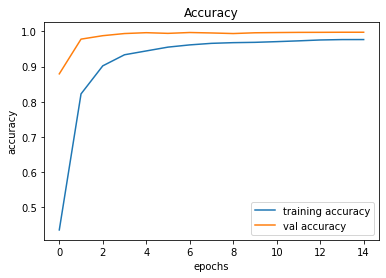

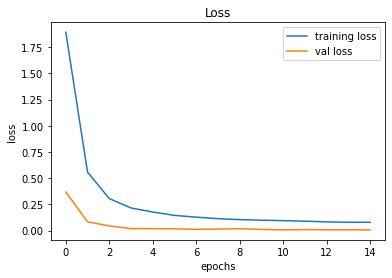

In [ ]:
plt.figure(0)
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

plt.figure(1)
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

Повторим все действия, которые мы делали для подготовки тренировочного набора данных, для тестовых данных.

In [ ]:
test = pd.read_csv(data_dir + 'Test.csv')

labels = test["ClassId"].values
images = test["Path"].values

data=[]

for a in images:
  image = Image.open(data_dir + '/' + a)
  image = image.resize((height,width))
  image = np.array(image)
  data.append(image)

In [ ]:
X_pred = np.array(data)
X_pred = X_pred/255

Получим предсказание величин для тестовой выборки.

In [ ]:
pred = model.predict_classes(X_pred)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Выведем величину метрики точности для тестового набора данных.

In [ ]:
from sklearn.metrics import accuracy_score

print('Test Data accuracy: ',accuracy_score(labels, pred)*100)

Test Data accuracy:  98.36896278701505


## Классификация изображений (Практическая часть)

Вашей задачей в данной лабораторной будет построение модели мультиклассовой классификации медицинских изображений на основе сверточных нейронных сетей.

https://www.kaggle.com/datasets/gennadiimanzhos/medical-mnist-train-test-val/data?select=train

Ниже приведен блок кода для загрузки тренировочной, тестовой и валидационной выборки.

In [ ]:
%%capture
!wget https://www.dropbox.com/scl/fi/x6hifnqqkuq1p33vr109s/Medical_train.zip?rlkey=vr1ob1xmj5bkfa2r21ef5uwnd&dl=0
!wget https://www.dropbox.com/scl/fi/8n9q6au9qcnpiwtwtojkm/Medical_test.zip?rlkey=j42oncxl79hp0uvgz3gz66ev4&dl=0
!wget https://www.dropbox.com/scl/fi/a17q72jelw3j7svdhsuiq/Medical_val.zip?rlkey=jo2bagqzwvq7uol2hw5lpjzmz&dl=0

Архитектура нейронной сети должна быть составлена самостоятельно и не содержать предобученных весов.

Оценка полученного решения складывается из двух факторов:

1. Значение метрики Accuracy_score.
2. Общее время, которое потребовалось модели для предсказания всех меток из валидационного датасета.